# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split,GridSearchCV

from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler,PolynomialFeatures 

from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import mutual_info_classif

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,classification_report
from sklearn.metrics import plot_roc_curve,roc_curve,auc,precision_recall_curve

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pandas_profiling import ProfileReport

In [2]:
%matplotlib inline

# Reading Dataset

In [3]:
df=pd.read_csv('train.csv',index_col=0)
df.head()

agency_name    inspector_name  \
ticket_id                                                                     
22056      Buildings, Safety Engineering & Env Department   Sims, Martinzie   
27586      Buildings, Safety Engineering & Env Department  Williams, Darrin   
22062      Buildings, Safety Engineering & Env Department   Sims, Martinzie   
22084      Buildings, Safety Engineering & Env Department   Sims, Martinzie   
22093      Buildings, Safety Engineering & Env Department   Sims, Martinzie   

                               violator_name  violation_street_number  \
ticket_id                                                               
22056      INVESTMENT INC., MIDWEST MORTGAGE                   2900.0   
27586               Michigan, Covenant House                   4311.0   
22062                        SANDERS, DERRON                   1449.0   
22084                           MOROSI, MIKE                   1441.0   
22093                        NATHANIEL, NEAL                   2449.0   

          violation_street_name  violation_zip_code  \
ticket_id                                             
22056                     TYLER                 NaN   
27586                   CENTRAL                 NaN   
22062                LONGFELLOW                 NaN   
22084                LONGFELLOW                 NaN   
22093                 CHURCHILL                 NaN   

           mailing_address_str_number mailing_address_str_name     city state  \
ticket_id                                                                       
22056                             3.0                S. WICKER  CHICAGO    IL   
27586                          2959.0       Martin Luther King  Detroit    MI   
22062                         23658.0                 P.O. BOX  DETROIT    MI   
22084                             5.0                ST. CLAIR  DETROIT    MI   
22093                          7449.0                CHURCHILL  DETROIT    MI   

           ... clean_up_cost judgment_amount payment_amount balance_due  \
ticket_id  ...                                                            
22056      ...           0.0           305.0            0.0       305.0   
27586      ...           0.0           855.0          780.0        75.0   
22062      ...           0.0             0.0            0.0         0.0   
22084      ...           0.0             0.0            0.0         0.0   
22093      ...           0.0             0.0            0.0         0.0   

                  payment_date      payment_status collection_status  \
ticket_id                                                              
22056                      NaN  NO PAYMENT APPLIED               NaN   
27586      2005-06-02 00:00:00        PAID IN FULL               NaN   
22062                      NaN  NO PAYMENT APPLIED               NaN   
22084                      NaN  NO PAYMENT APPLIED               NaN   
22093                      NaN  NO PAYMENT APPLIED               NaN   

          grafitti_status                         compliance_detail  \
ticket_id                                                             
22056                 NaN               non-compliant by no payment   
27586                 NaN  compliant by late payment within 1 month   
22062                 NaN            not responsible by disposition   
22084                 NaN            not responsible by disposition   
22093                 NaN            not responsible by disposition   

           compliance  
ticket_id              
22056             0.0  
27586             1.0  
22062             NaN  
22084             NaN  
22093             NaN  

[5 rows x 33 columns]

**Excluding Features in order to prevent Data-Leakage**

In [4]:
exclude_features=['payment_amount','payment_date','payment_status','balance_due','collection_status','compliance_detail']
df.drop(exclude_features,axis=1,inplace=True)

**droping null compliance instances because they implies that the violator was found out not responsible**

In [5]:
df.dropna(subset=['compliance'],inplace=True)

In [6]:
df.columns

Index(['agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'grafitti_status', 'compliance'],
      dtype='object')

In [7]:
df.isnull().sum()

agency_name                        0
inspector_name                     0
violator_name                     26
violation_street_number            0
violation_street_name              0
violation_zip_code            159880
mailing_address_str_number      2558
mailing_address_str_name           3
city                               0
state                             84
zip_code                           1
non_us_str_code               159877
country                            0
ticket_issued_date                 0
hearing_date                     227
violation_code                     0
violation_description              0
disposition                        0
fine_amount                        0
admin_fee                          0
state_fee                          0
late_fee                           0
discount_amount                    0
clean_up_cost                      0
judgment_amount                    0
grafitti_status               159880
compliance                         0
d

In [8]:
df.shape

(159880, 27)

**Dropping feature which have more than 90% null values**

In [9]:
maxnullFeatures=list(df.columns[df.isnull().sum()/len(df)>0.9])

In [10]:
df.drop(maxnullFeatures,axis=1,inplace=True)

**Changing the dtype to DateTime**

In [11]:
df['ticket_issued_date']=pd.to_datetime(df['ticket_issued_date'],format='%Y-%m-%d')

df['hearing_date']=pd.to_datetime(df['hearing_date'],format='%Y-%m-%d')

In [12]:
numerical_col=list(df.select_dtypes(exclude=[object,'datetime']).columns)

In [13]:
object_col=list(df.select_dtypes(include=object).columns)

# Exploratory Data Analysis

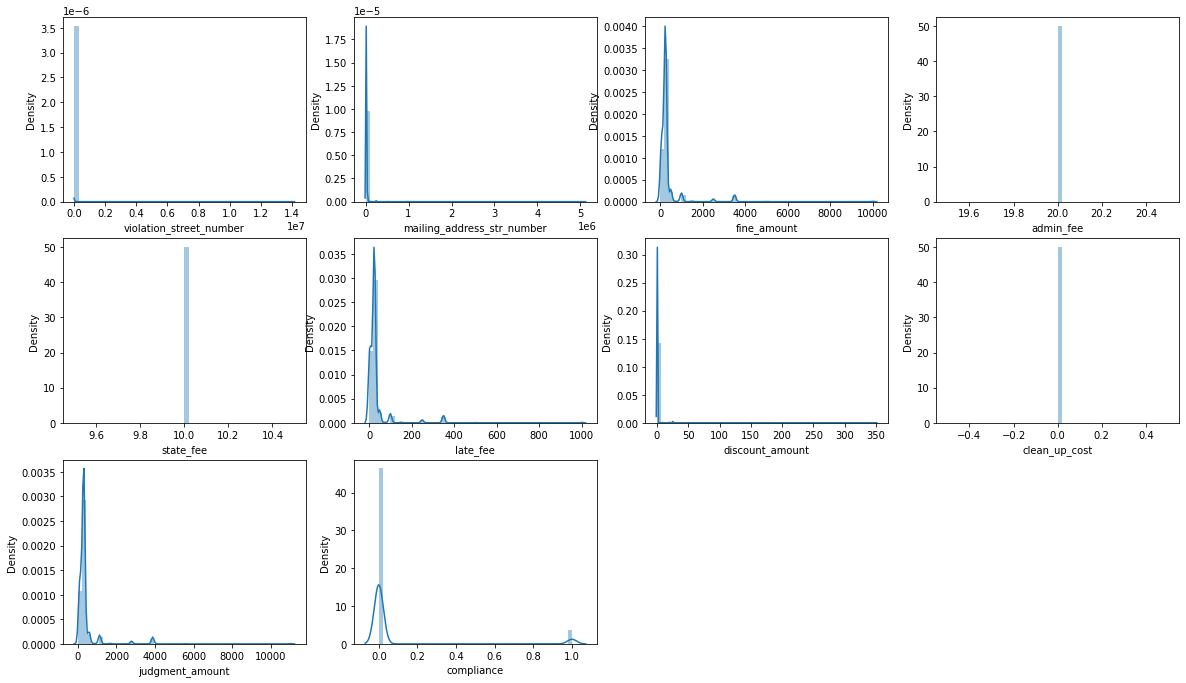

In [14]:
plt.figure(figsize=(20,len(numerical_col)*4))
i=1
for cname in numerical_col:
    plt.subplot(len(numerical_col),4,i)
    sns.distplot(df[cname])
    i+=1

Insights
1. 'admin_fee', 'state_fee', 'clean_up_cost' have constant values, so they can be removed

2. compliance is type of imbalanced Class

In [15]:
df[['admin_fee','state_fee','clean_up_cost']].nunique()

admin_fee        1
state_fee        1
clean_up_cost    1
dtype: int64

In [16]:
df.drop(['admin_fee','state_fee','clean_up_cost'],axis=1,inplace=True)

In [17]:
report=ProfileReport(df)

In [18]:
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Insights**
1. variable violation_code,violation_description has 189 & 207 distinct values and 5 distinct values covers the frequency of 80% of the data
2. variable inspector_name,violator_name has 159 & 84656 distinct values and none of the distinct value has major frequency
3. Disposition variable is highly correlated with compliance

<AxesSubplot:>

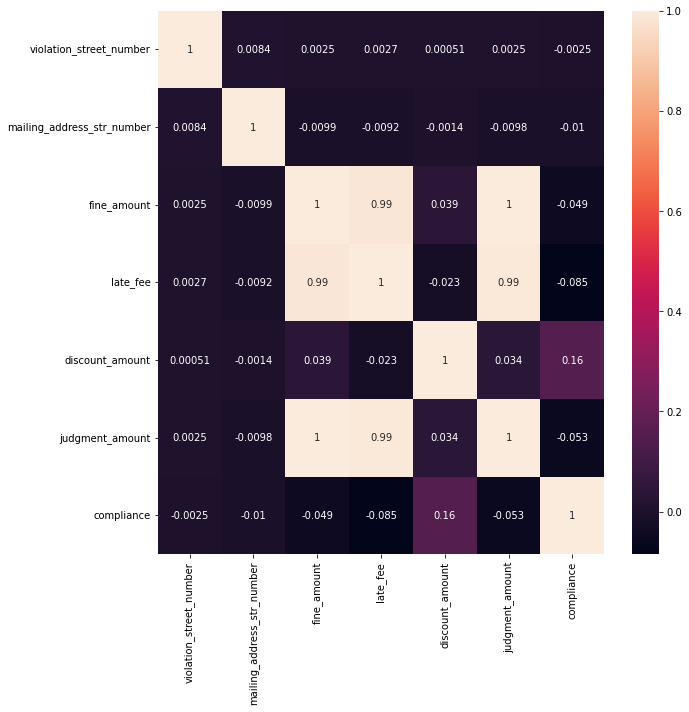

In [19]:
correlation=df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation,annot=True)

Insights
1. fine_amount, late_fee, judgment_amount are highly correlated features to one another
2. discount_amount is correlated to compliance among numerical_col

<AxesSubplot:xlabel='compliance', ylabel='disposition'>

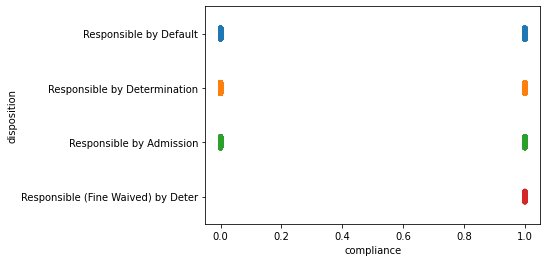

In [20]:
sns.stripplot(x='compliance',y='disposition',data=df)

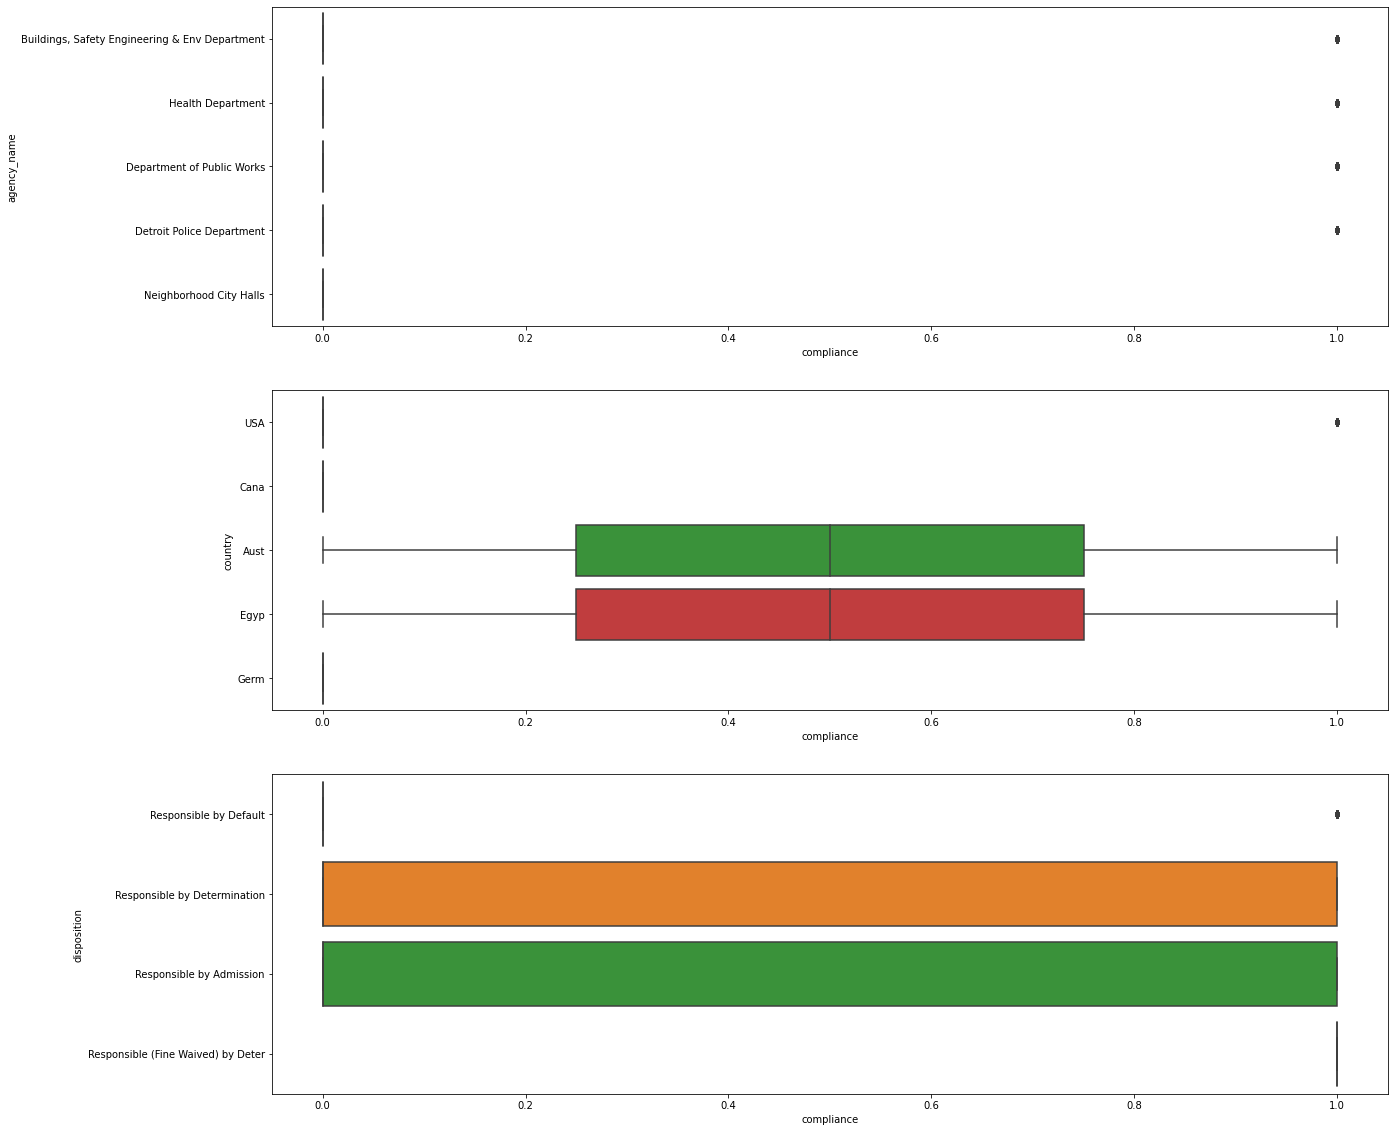

In [21]:
plt.figure(figsize=(20,20))
i=1
for cname in ['agency_name','country','disposition']:
    plt.subplot(3,1,i)
    sns.boxplot(x='compliance',y=cname,data=df)
    i+=1

**Insights**
1. Can and Germ country belongs to compliance class(0)
2. Responsible by default disposition are generally in compliance class(0)
3. Responsible(Fine Waived) by Deter are generally in non-compliance class(1)
    

# Feature Engineering

1. Replacing less frequent values of feature violation_description with 'others' so that cardinality is reduced to 5
2. Creating new feature duration that is the duration between the ticket_issued_date and hearing_date

In [22]:
a=df['violation_description'].value_counts()/len(df)  #
a.sort_values(ascending=False)
a[:5].sum()

0.8033337503127346

<AxesSubplot:xlabel='violation_description'>

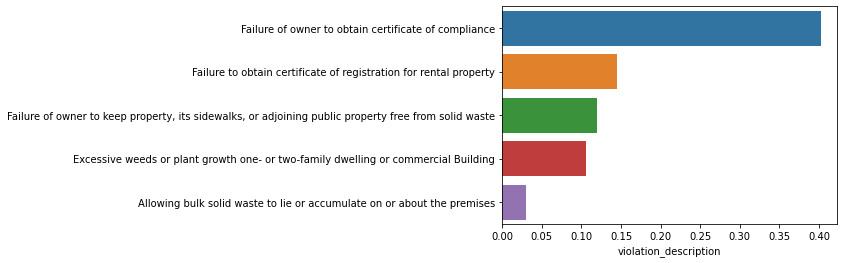

In [23]:
sns.barplot(a[:5],a.index[:5],)

In [24]:
df[object_col].nunique()

agency_name                     5
inspector_name                159
violator_name               84656
violation_street_name        1716
mailing_address_str_name    28440
city                         4093
state                          59
zip_code                     4622
country                         5
violation_code                189
violation_description         207
disposition                     4
dtype: int64

In [25]:
df['violation_description']=df['violation_description'].map(lambda x:'others' if x not in(list(a.index[:4])) else x)

In [26]:
usefull_obj=['agency_name','state','country','violation_code','disposition','violation_description']

No_use_high_ca=list(set(object_col)-set(usefull_obj))   #Not useful and high cardinallity columns

In [27]:
df.drop(No_use_high_ca,axis=1,inplace=True)

In [28]:
df['Address_diff']=(df.violation_street_number==df.mailing_address_str_number).astype(int)

df.drop(['violation_street_number','mailing_address_str_number'],axis=1,inplace=True)

df.state.fillna('Missing',inplace=True)

df['Duration']=(df['hearing_date']-df['ticket_issued_date']).dt.days

In [29]:
df.Duration[df.Duration.isnull()]=0

In [30]:
df.drop(['hearing_date','ticket_issued_date'],axis=1,inplace=True)

In [31]:
df.head()

agency_name state country  \
ticket_id                                                                 
22056      Buildings, Safety Engineering & Env Department    IL     USA   
27586      Buildings, Safety Engineering & Env Department    MI     USA   
22046      Buildings, Safety Engineering & Env Department    CA     USA   
18738      Buildings, Safety Engineering & Env Department    MI     USA   
18735      Buildings, Safety Engineering & Env Department    MI     USA   

          violation_code                              violation_description  \
ticket_id                                                                     
22056          9-1-36(a)  Failure of owner to obtain certificate of comp...   
27586         61-63.0600                                             others   
22046          9-1-36(a)  Failure of owner to obtain certificate of comp...   
18738         61-63.0500                                             others   
18735         61-63.0100                                             others   

                            disposition  fine_amount  late_fee  \
ticket_id                                                        
22056            Responsible by Default        250.0      25.0   
27586      Responsible by Determination        750.0      75.0   
22046            Responsible by Default        250.0      25.0   
18738            Responsible by Default        750.0      75.0   
18735            Responsible by Default        100.0      10.0   

           discount_amount  judgment_amount  compliance  Address_diff  \
ticket_id                                                               
22056                  0.0            305.0         0.0             0   
27586                  0.0            855.0         1.0             0   
22046                  0.0            305.0         0.0             0   
18738                  0.0            855.0         0.0             0   
18735                  0.0            140.0         0.0             1   

           Duration  
ticket_id            
22056         369.0  
27586         378.0  
22046         323.0  
18738         253.0  
18735         251.0

**Imbalanced-Class**

<AxesSubplot:xlabel='compliance', ylabel='Count'>

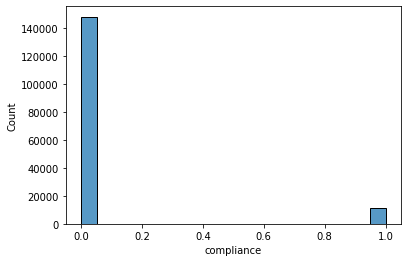

In [32]:
sns.histplot(df['compliance'])

In [33]:
df.isnull().sum()    #checking null values

agency_name              0
state                    0
country                  0
violation_code           0
violation_description    0
disposition              0
fine_amount              0
late_fee                 0
discount_amount          0
judgment_amount          0
compliance               0
Address_diff             0
Duration                 0
dtype: int64

In [34]:
X=df.drop('compliance',axis=1)
y=df['compliance']

**stratify=y to deal with imbalanced class**

In [35]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=1)

In [36]:
X_train[usefull_obj].head()

agency_name state country  \
ticket_id                                                                 
209133     Buildings, Safety Engineering & Env Department    MI     USA   
217806                         Department of Public Works    CA     USA   
179638     Buildings, Safety Engineering & Env Department    MI     USA   
280583                          Detroit Police Department    MI     USA   
216807     Buildings, Safety Engineering & Env Department    MI     USA   

          violation_code                   disposition  \
ticket_id                                                
209133         9-1-81(a)        Responsible by Default   
217806           22-2-45        Responsible by Default   
179638         9-1-36(a)  Responsible by Determination   
280583           9-1-104        Responsible by Default   
216807         9-1-81(a)        Responsible by Default   

                                       violation_description  
ticket_id                                                     
209133     Failure to obtain certificate of registration ...  
217806                                                others  
179638     Failure of owner to obtain certificate of comp...  
280583     Excessive weeds or plant growth one- or two-fa...  
216807     Failure to obtain certificate of registration ...

# One-Hot Encoding

In [37]:
my_encoder=OneHotEncoder(handle_unknown='ignore',sparse=False)

OH_encoded_train=pd.DataFrame(my_encoder.fit_transform(X_train[usefull_obj]),index=X_train.index)

OH_encoded_test=pd.DataFrame(my_encoder.transform(X_test[usefull_obj]),index=X_test.index)

X_train.drop(usefull_obj,axis=1,inplace=True)
X_test.drop(usefull_obj,axis=1,inplace=True)

X_train=pd.merge(X_train,OH_encoded_train,left_index=True,right_index=True)
X_test=pd.merge(X_test,OH_encoded_test,left_index=True,right_index=True)

In [38]:
X_train.shape

(119910, 258)

In [39]:
X_test.shape

(39970, 258)

# Mutual Information

In [40]:
discrete_features=X_train.dtypes==int

In [41]:
mi=mutual_info_classif(X_train,y_train,discrete_features=discrete_features)

In [42]:
mi=pd.Series(mi,index=X_train.columns)
MiImpFea=mi.sort_values(ascending=False)[:50].index

# XGBoost Classifier (model training and its evaluation)

[16:21:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Accuracy score: 
 0.9440830622967226

Precision score: 
 0.9029126213592233

Recall score: 
 0.2566402207657813

F1 score: 
 0.3996776792908945

Confusion Matrix: 
 [[36991    80]
 [ 2155   744]]

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     37071
         1.0       0.90      0.26      0.40      2899

    accuracy                           0.94     39970
   macro avg       0.92      0.63      0.69     39970
weighted avg       0.94      0.94      0.93     39970



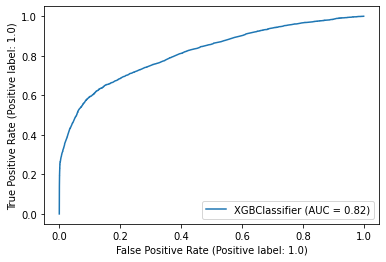

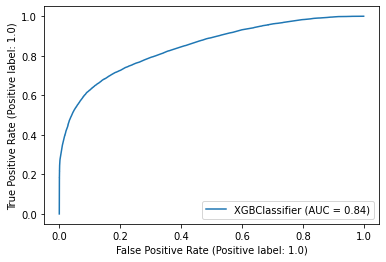

In [43]:
model1=XGBClassifier()
model1.fit(X_train,y_train)
predictions1=model1.predict(X_test)

print('\nAccuracy score: \n',accuracy_score(y_test,predictions1))
print('\nPrecision score: \n',precision_score(y_test,predictions1))
print('\nRecall score: \n',recall_score(y_test,predictions1))
print('\nF1 score: \n',f1_score(y_test,predictions1))
print('\nConfusion Matrix: \n',confusion_matrix(y_test,predictions1))
print('\nClassification Report: \n',classification_report(y_test,predictions1))

plot_roc_curve(model1,X_test,y_test)

plot_roc_curve(model1,X_train,y_train)

In [44]:
XGBFeaImp=pd.Series(model1.feature_importances_,index=X_train.columns)
Xgb_fea=XGBFeaImp.sort_values(ascending=False)[:50].index

# Over-sampling of minority class to handle imbalanced data

In [45]:
sampler=SMOTE()
X_over,y_over=sampler.fit_resample(X_train,y_train)

<AxesSubplot:xlabel='compliance', ylabel='Count'>

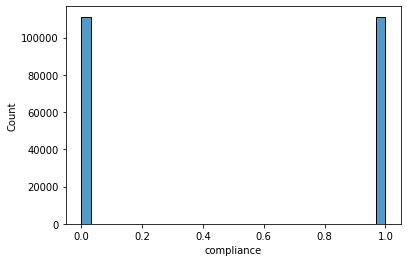

In [46]:
sns.histplot(y_over)

### Training and evaluation of XGBoost model on over-sampled dataset

[16:22:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score: 	 0.905479109331999
Precision score: 	 0.3821399839098954
Recall score: 	 0.49154880993446015
F1 score: 	 0.42999396499698245
Confusion Matrix: 
 [[34767  2304]
 [ 1474  1425]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     37071
         1.0       0.38      0.49      0.43      2899

    accuracy                           0.91     39970
   macro avg       0.67      0.71      0.69     39970
weighted avg       0.92      0.91      0.91     39970



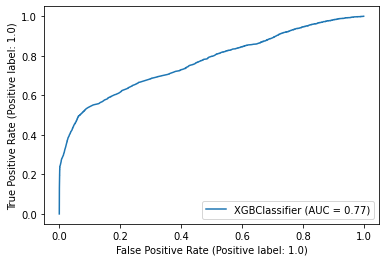

In [47]:
model2=XGBClassifier()
model2.fit(X_over,y_over)

predictions2=model2.predict(X_test)

print('Accuracy score: \t',accuracy_score(y_test,predictions2))
print('Precision score: \t',precision_score(y_test,predictions2))
print('Recall score: \t',recall_score(y_test,predictions2))
print('F1 score: \t',f1_score(y_test,predictions2))
print('Confusion Matrix: \n',confusion_matrix(y_test,predictions2))
print('Classification Report: \n',classification_report(y_test,predictions2))

plot_roc_curve(model2,X_test,y_test)

# Random Forest Classifier

Accuracy score: 	 0.9354015511633725
Precision score: 	 0.6129722024233785
Recall score: 	 0.29665401862711277
F1 score: 	 0.39981403998140397
Confusion Matrix: 
 [[36528   543]
 [ 2039   860]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     37071
         1.0       0.61      0.30      0.40      2899

    accuracy                           0.94     39970
   macro avg       0.78      0.64      0.68     39970
weighted avg       0.92      0.94      0.92     39970



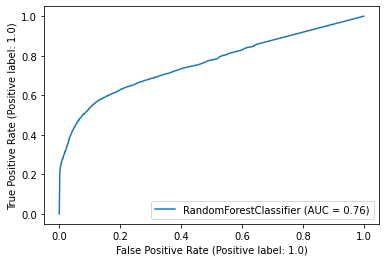

In [48]:
model3=RandomForestClassifier()
model3.fit(X_train,y_train)
predictions3=model3.predict(X_test)

print('Accuracy score: \t',accuracy_score(y_test,predictions3))
print('Precision score: \t',precision_score(y_test,predictions3))
print('Recall score: \t',recall_score(y_test,predictions3))
print('F1 score: \t',f1_score(y_test,predictions3))
print('Confusion Matrix: \n',confusion_matrix(y_test,predictions3))
print('Classification Report: \n',classification_report(y_test,predictions3))

plot_roc_curve(model3,X_test,y_test)

### Training of Random Forest model on over-sampled dataset

Accuracy score: 	 0.8976732549412059
Precision score: 	 0.34191664454473053
Recall score: 	 0.4442911348740945
F1 score: 	 0.3864386438643864
Confusion Matrix: 
 [[34592  2479]
 [ 1611  1288]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.93      0.94     37071
         1.0       0.34      0.44      0.39      2899

    accuracy                           0.90     39970
   macro avg       0.65      0.69      0.67     39970
weighted avg       0.91      0.90      0.90     39970



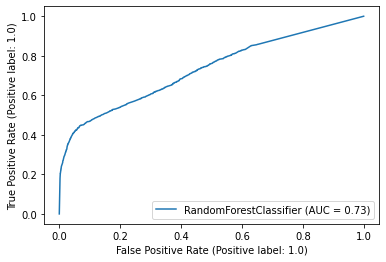

In [49]:
model4=RandomForestClassifier()
model4.fit(X_over,y_over)
predictions4=model4.predict(X_test)

print('Accuracy score: \t',accuracy_score(y_test,predictions4))
print('Precision score: \t',precision_score(y_test,predictions4))
print('Recall score: \t',recall_score(y_test,predictions4))
print('F1 score: \t',f1_score(y_test,predictions4))
print('Confusion Matrix: \n',confusion_matrix(y_test,predictions4))
print('Classification Report: \n',classification_report(y_test,predictions4))

plot_roc_curve(model4,X_test,y_test)

# Logistic Regression

Accuracy score: 	 0.9348761571178383
Precision score: 	 0.9111111111111111
Recall score: 	 0.11314246291824767
F1 score: 	 0.2012887388769561
Confusion Matrix: 
 [[37039    32]
 [ 2571   328]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     37071
         1.0       0.91      0.11      0.20      2899

    accuracy                           0.93     39970
   macro avg       0.92      0.56      0.58     39970
weighted avg       0.93      0.93      0.91     39970



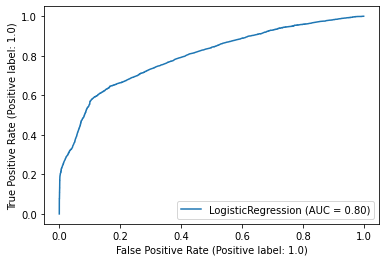

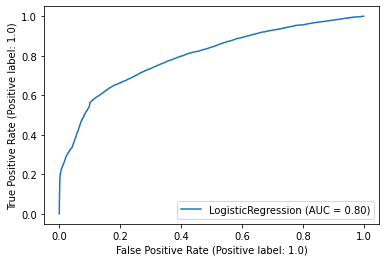

In [50]:
model5=LogisticRegression()
model5.fit(X_train,y_train)
predictions5=model5.predict(X_test)

print('Accuracy score: \t',accuracy_score(y_test,predictions5))
print('Precision score: \t',precision_score(y_test,predictions5))
print('Recall score: \t',recall_score(y_test,predictions5))
print('F1 score: \t',f1_score(y_test,predictions5))
print('Confusion Matrix: \n',confusion_matrix(y_test,predictions5))
print('Classification Report: \n',classification_report(y_test,predictions5))

plot_roc_curve(model5,X_test,y_test)
plot_roc_curve(model5,X_train,y_train)

### Logistic Regression after scaling the data

Accuracy score: 	 0.9353765323992995
Precision score: 	 0.8449781659388647
Recall score: 	 0.13349430838220075
F1 score: 	 0.23056300268096513
Confusion Matrix: 
 [[37000    71]
 [ 2512   387]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     37071
         1.0       0.84      0.13      0.23      2899

    accuracy                           0.94     39970
   macro avg       0.89      0.57      0.60     39970
weighted avg       0.93      0.94      0.91     39970



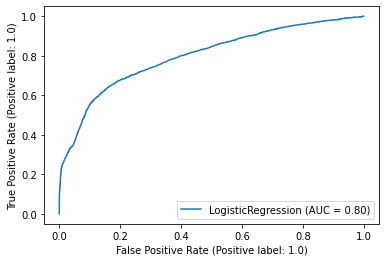

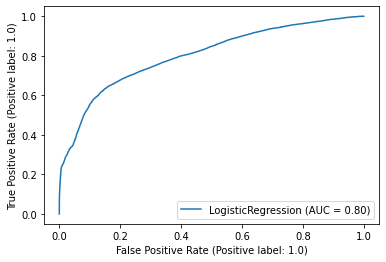

In [51]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

model6=LogisticRegression()
model6.fit(X_train_scaled,y_train)
predictions6=model6.predict(X_test_scaled)

print('Accuracy score: \t',accuracy_score(y_test,predictions6))
print('Precision score: \t',precision_score(y_test,predictions6))
print('Recall score: \t',recall_score(y_test,predictions6))
print('F1 score: \t',f1_score(y_test,predictions6))
print('Confusion Matrix: \n',confusion_matrix(y_test,predictions6))
print('Classification Report: \n',classification_report(y_test,predictions6))

plot_roc_curve(model6,X_test_scaled,y_test)
plot_roc_curve(model6,X_train_scaled,y_train)

### Logistic Regression on over-sampled data

Accuracy score: 	 0.8619964973730297
Precision score: 	 0.2844671388568605
Recall score: 	 0.595722662987237
F1 score: 	 0.38506131549609807
Confusion Matrix: 
 [[32727  4344]
 [ 1172  1727]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.88      0.92     37071
         1.0       0.28      0.60      0.39      2899

    accuracy                           0.86     39970
   macro avg       0.62      0.74      0.65     39970
weighted avg       0.92      0.86      0.88     39970



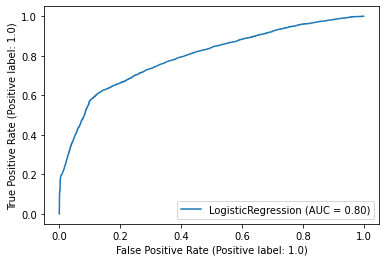

In [52]:
model7=LogisticRegression()
model7.fit(X_over,y_over)
predictions7=model7.predict(X_test)

print('Accuracy score: \t',accuracy_score(y_test,predictions7))
print('Precision score: \t',precision_score(y_test,predictions7))
print('Recall score: \t',recall_score(y_test,predictions7))
print('F1 score: \t',f1_score(y_test,predictions7))
print('Confusion Matrix: \n',confusion_matrix(y_test,predictions7))
print('Classification Report: \n',classification_report(y_test,predictions7))

plot_roc_curve(model7,X_test,y_test)

# Hyper-Parameter tuning
Selected XGBoost model because it lead to better AUC score than Random Forest and Logistic Regression

In [53]:
#param_grid={'n_estimators':[100,150,200],'max_depth':[4,6],'reg_lambda':[1,2],'gamma':[0,1],'subsample':[0.9,1],'learning_rate':[0.3,0.1]}

#gscv=GridSearchCV(estimator=XGBClassifier(),param_grid=param_grid,cv=2,scoring='roc_auc',verbose=1)

#gscv.fit(X_train,y_train)

#gscv.best_estimator_

#gscv.best_params_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Training with tuned model

[16:26:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score: 	 0.9440580435326494
Precision score: 	 0.9047619047619048
Recall score: 	 0.2556053811659193
F1 score: 	 0.39860139860139865
Confusion Matrix: 
 [[36993    78]
 [ 2158   741]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     37071
         1.0       0.90      0.26      0.40      2899

    accuracy                           0.94     39970
   macro avg       0.92      0.63      0.68     39970
weighted avg       0.94      0.94      0.93     39970



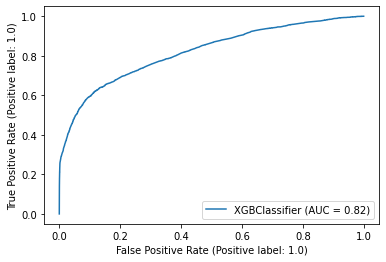

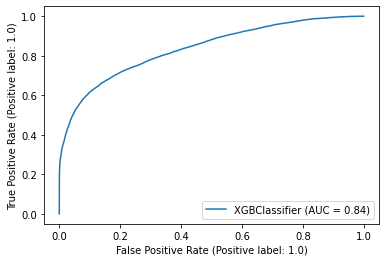

In [54]:
model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, monotone_constraints='()', n_estimators=150, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

model.fit(X_train,y_train)

predictions=model.predict(X_test)

print('Accuracy score: \t',accuracy_score(y_test,predictions))
print('Precision score: \t',precision_score(y_test,predictions))
print('Recall score: \t',recall_score(y_test,predictions))
print('F1 score: \t',f1_score(y_test,predictions))
print('Confusion Matrix: \n',confusion_matrix(y_test,predictions))
print('Classification Report: \n',classification_report(y_test,predictions))

plot_roc_curve(model,X_test,y_test)

plot_roc_curve(model,X_train,y_train)

# Training on only important features

In [55]:
important_fea=list(set(set(MiImpFea)|set(Xgb_fea)))

[16:27:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score: 	 0.9440080060045034
Precision score: 	 0.8948626045400239
Recall score: 	 0.258364953432218
F1 score: 	 0.40096359743040677
Confusion Matrix: 
 [[36983    88]
 [ 2150   749]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     37071
         1.0       0.89      0.26      0.40      2899

    accuracy                           0.94     39970
   macro avg       0.92      0.63      0.69     39970
weighted avg       0.94      0.94      0.93     39970



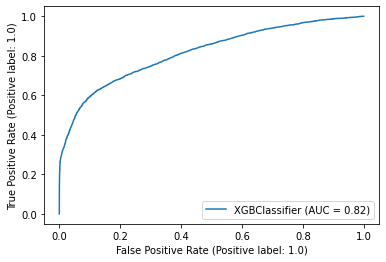

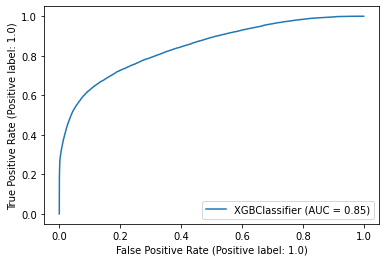

In [56]:
model8=XGBClassifier()
model8.fit(X_train[important_fea],y_train)

predictions8=model8.predict(X_test[important_fea])

print('Accuracy score: \t',accuracy_score(y_test,predictions8))
print('Precision score: \t',precision_score(y_test,predictions8))
print('Recall score: \t',recall_score(y_test,predictions8))
print('F1 score: \t',f1_score(y_test,predictions8))
print('Confusion Matrix: \n',confusion_matrix(y_test,predictions8))
print('Classification Report: \n',classification_report(y_test,predictions8))

plot_roc_curve(model8,X_test[important_fea],y_test)
plot_roc_curve(model8,X_train[important_fea],y_train)

[16:27:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score: 	 0.9440580435326494
Precision score: 	 0.9027946537059538
Recall score: 	 0.256295274232494
F1 score: 	 0.39924771628156913
Confusion Matrix: 
 [[36991    80]
 [ 2156   743]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     37071
         1.0       0.90      0.26      0.40      2899

    accuracy                           0.94     39970
   macro avg       0.92      0.63      0.68     39970
weighted avg       0.94      0.94      0.93     39970



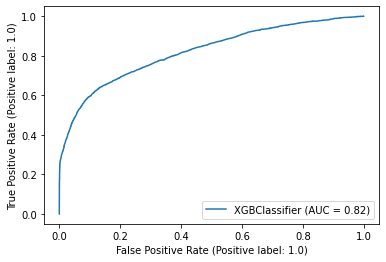

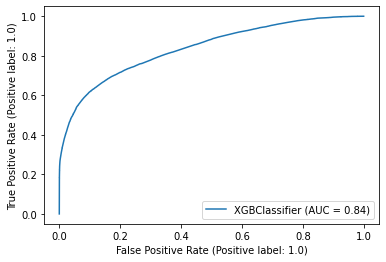

In [57]:
model8=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, monotone_constraints='()', n_estimators=150, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)
model8.fit(X_train[important_fea],y_train)

predictions8=model8.predict(X_test[important_fea])

print('Accuracy score: \t',accuracy_score(y_test,predictions8))
print('Precision score: \t',precision_score(y_test,predictions8))
print('Recall score: \t',recall_score(y_test,predictions8))
print('F1 score: \t',f1_score(y_test,predictions8))
print('Confusion Matrix: \n',confusion_matrix(y_test,predictions8))
print('Classification Report: \n',classification_report(y_test,predictions8))

plot_roc_curve(model8,X_test[important_fea],y_test)
plot_roc_curve(model8,X_train[important_fea],y_train)

# Model Comparision and Summary
**1. XGBoost:**

        i.   Without over-sampled data set----- AUC: 0.82 || Precision: 0.90 || Recall: 0.26
        ii.  With over-sampled data set ------- AUC: 0.77 || Precision: 0.38 || Recall: 0.49
        iii. Using only important features ---- AUC: 0.82 || Precision: 0.90 || Recall: 0.26

**2. Random Forest:**

        i.   Without over-sampled data set----- AUC: 0.76 || Precision: 0.61 || Recall: 0.29
        ii.  With over-sampled data set ------- AUC: 0.73 || Precision: 0.34 || Recall: 0.44

**3. Logistic Regression:**

        i.   Without over-sampled data set----- AUC: 0.80 || Precision: 0.91 || Recall: 0.11
        ii.  With scaled data set ------------- AUC: 0.80 || Precision: 0.84 || Recall: 0.13
        iii. With over-sampled data set ------- AUC: 0.80 || Precision: 0.28 || Recall: 0.60

**4. Tuned XGBoost:**

        i.   Without over-sampled data set----- AUC: 0.82 || Precision: 0.90 || Recall: 0.26
        ii.  Using only important features ---- AUC: 0.82 || Precision: 0.90 || Recall: 0.26

In our case, with over-sampling of minority class, recall score increases while precision score decreases.

As enforcing unpaid blight fines is a costly and tedious process, we want our resources to be utilised effectively,i.e., allocating resources to follow up only those residents which are presicely going to be defaulter(not-paying). Hence, AUC and precision are used as evaluation metrics.

GridSearch tuned XGBoost model with only important features is selected because its AUC is 0.82 and precision score is 0.90 which is higher than other models and preferring only important features for modelling because of decrease in computational time.